In [1266]:

from __future__ import division, unicode_literals, print_function  # for compatibility with Python 2 and 3

import matplotlib as mpl
import matplotlib.pyplot as plt
from jones_matrix import JonesMatrix as jm
from jones_matrix import Phases as ph
# change the following to %matplotlib notebook for interactive plotting

In [1267]:
%matplotlib inline

# Optionally, tweak styles.
mpl.rc('figure',  figsize=(10, 6))
mpl.rc('image', cmap='gray')

import numpy as np
import pandas as pd
from pandas import DataFrame, Series  # for convenience
import numba as nb
import pims
import trackpy as tp
import matplotlib.animation as animation

This is a markdown cell. You can change the cell type in the menu `cell->cell type`.
You can read more about [markdown](http://jupyter-notebook.readthedocs.io/en/latest/examples/Notebook/Working%20With%20Markdown%20Cells.html) too.

The cell below defines the director field on a radial droplet the function `f` adds a twist from ref: Liquid Crystals, 1999, Vol. 26, No. 5, 753-758.

$$ f(r) = \frac{1}{\sqrt{r}}\sin\left(\pi\frac{ln(r/r_{min})}{ln(r_{max}/r_{min}}\right) $$


with:

$r$ the radial position in the drop

$r_{max}$ the radius of the drop

$r_{min}$ the radius of the small inclusion contained in the drop

For a point of coordinates (x,y,z), the spherical coordinates are given by

$ r = \sqrt{x^{2}+y^{2}+z^{2}} $

$ \theta = \cos^{-1}\left(\frac{z}{\sqrt{x^{2}+y^{2}+z^{2}}}\right) $

$ \phi = \tan^{-1}\left(\frac{y}{x}\right) $

At this point, the director is defined by the polar coordinates

$n_r = \left(1-0.5\times b^{2}\times f(r)^{2} \right) \times r $

$n_{\phi} = \phi + b \times f(r) = \gamma$

$n_{\theta} = \theta = \beta $

with b being the 'twist amplitude'




In [1268]:
def f(r,rmin,rmax):
    return 1/np.sqrt(r)*np.sin(np.pi*np.log(r/rmin)/np.log(rmax/rmin))

def rd(x,y,z):
    return np.sqrt(x**2+y**2+z**2)

def tet(x,y,z):
    return np.arccos(z/np.sqrt(x**2+y**2+z**2))

def phi(x,y,z):
    return np.arctan2(y,x)

def nr(x,y,z,b,rmin,rmax):
    return (1-0.5*(b**2)*(f(rd(x,y,z),rmin,rmax)**2))*rd(x,y,z)

def nphi(x,y,z,b,rmin,rmax):
    return b*f(rd(x,y,z),rmin,rmax)+phi(x,y,z)

def ntet(x,y,z):
    return tet(x,y,z)

def nx(x,y,z,b,rmin,rmax):
    return nr(x,y,z,b,rmin,rmax)*np.sin(ntet(x,y,z))*np.cos(nphi(x,y,z,b,rmin,rmax))

def ny(x,y,z,b,rmin,rmax):
    return nr(x,y,z,b,rmin,rmax)*np.sin(ntet(x,y,z))*np.sin(nphi(x,y,z,b,rmin,rmax))

def nz(x,y,z,b,rmin,rmax):
    return nr(x,y,z,b,rmin,rmax)*np.cos(ntet(x,y,z))

def beta(x,y,z,b,rmin,rmax):
    return np.arccos(nz(x,y,z,b,rmin,rmax)/np.sqrt((nx(x,y,z,b,rmin,rmax))**2+(ny(x,y,z,b,rmin,rmax))**2+(nz(x,y,z,b,rmin,rmax))**2))

def gamma(x,y,z,b,rmin,rmax):
    return np.arctan(ny(x,y,z,b,rmin,rmax)/nx(x,y,z,b,rmin,rmax))

In [1275]:
print(nphi(8,8,0,0,0.1,10))
print(jm.jones_matrix(-np.pi/4,ph.compute_phiex(ntet(8,-8,0),1.5,1.7,0.660,0.1),ph.compute_phiord(1.5,0.660,0.1)))
print(jm.jones_matrix(7*np.pi/4,ph.compute_phiex(ntet(8,-8,0),1.5,1.7,0.660,0.1),ph.compute_phiord(1.5,0.660,0.1)))
print(np.cos(-np.pi/2))
print(np.cos(3*np.pi/2))

0.785398163397
[[ 0.04736646+0.99434439j  0.09494838-0.00452295j]
 [ 0.09494838-0.00452295j  0.04736646+0.99434439j]]
[[ 0.04736646+0.99434439j  0.09494838-0.00452295j]
 [ 0.09494838-0.00452295j  0.04736646+0.99434439j]]
6.12323399574e-17
-1.83697019872e-16


In [141]:
def polarizer(ang):
    return np.array([[np.cos(ang)**2,np.cos(ang)*np.sin(ang)],
                     [np.cos(ang)*np.sin(ang),np.sin(ang)**2]],
                    dtype=np.complex)

In [142]:
pol = np.array([[1,0],[0,0]],dtype=np.complex)
ana = np.array([[0,0],[0,1]],dtype=np.complex)

In [143]:
def tw(r,rmax,a):
    return (a/rmax)*(rmax-r)

def rd(x,y,z):
    return np.sqrt(x**2+y**2+z**2)

def tet(x,y,z):
    return np.arccos(z/np.sqrt(x**2+y**2+z**2))

def phi(x,y,z):
    return np.arctan(y/x)


def nr2(x,y,z):
    return rd(x,y,z)

def nphi2(x,y,z,a,rmax):
    return phi(x,y,z)+tw(rd(x,y,z),rmax,a)

def ntet2(x,y,z):
    return tet(x,y,z)

def nx2(x,y,z,a,rmax):
    return nr2(x,y,z)*np.sin(ntet2(x,y,z))*np.cos(nphi2(x,y,z,a,rmax))

def ny2(x,y,z,a,rmax):
    return nr2(x,y,z)*np.sin(ntet(x,y,z))*np.sin(nphi2(x,y,z,a,rmax))

def nz2(x,y,z):
    return nr2(x,y,z)*np.cos(ntet2(x,y,z))

def beta2(x,y,z,a,rmax):
    return np.arccos(nz2(x,y,z)/np.sqrt((nx2(x,y,z,a,rmax))**2+(ny2(x,y,z,a,rmax))**2+(nz2(x,y,z))**2))

def gamma2(x,y,z,a,rmax):
    return np.arctan(ny2(x,y,z,a,rmax)/nx2(x,y,z,a,rmax))

In [633]:
def rd(x,y,z):
    return np.sqrt(x**2+y**2+z**2)

def tet(x,y,z):
    return np.arccos(z/np.sqrt(x**2+y**2+z**2))

def phi(x,y,z):
    return np.arctan(y/x)

def beta3(x,y,z,eps1,eps2,rmax):
    return tet(x,y,z)*np.exp(-(rmax-rd(x,y,z))/eps1)+(tet(x,y,z)+(np.pi/2-tet(x,y,z))*(1-np.exp(-(x**2+y**2)/eps2)))*(1-np.exp(-(rmax-rd(x,y,z))/eps1))

def gamma3(x,y,z,eps1,eps3,rmax,g0):
    return phi(x,y,z)+g0*np.exp(-rd(x,y,z)/eps3)*(1-np.exp(-(rmax-rd(x,y,z))/eps1))

In [917]:
print(gamma3(0.1,0,0,0.5,0.5,5,np.pi/2))
phi(0.1,0,0)

1.28598794553


0.0

In [274]:
nphi(10,0,0,1,0.1,10)

3.8726732145403873e-17

In [1210]:
rmax = 5 #microns
rmin = rmax/50
n_ord = 1.55
n_ext = 1.70
lamb = 0.550 #microns
zres = 0.011
xres = 0.011
yres = xres
#wlen = lamb
b = 0
a = 0
eps1 = 0.1*rmax
eps2 = 100*rmax
eps3 = 0.4*rmax
g0 = 50/180*np.pi

In [1211]:
x = np.arange(-1,1,xres)
y = np.arange(-1,1,yres)
z = np.arange(-1,1,zres)

In [1276]:
def jm_mat(x,y,z,b,rmin,rmax,wlen):
    res_jm = np.ones((x.shape[0],y.shape[0],2,2),dtype=np.complex)
    res_jm[:,:] = np.identity(2,dtype=np.complex)
    for i,xi in enumerate(x):
        for j,yi in enumerate(y):
            for zi in z:
                if np.sqrt(xi**2+yi**2+zi**2) < 1:
                    bet = nphi(xi,yi,zi,b,rmin,rmax)
                    gam = ntet(xi,yi,zi)
                    phiex = ph.compute_phiex(bet,n_ord,n_ext,wlen,zres*rmax)
                    phior = ph.compute_phiord(n_ord,wlen,zres*rmax)
                    res_jm[i,j] = np.dot(jm.jones_matrix(gam,phiex,phior),
                                   res_jm[i,j])
    return res_jm

In [592]:
def jm_mat2(x,y,z,a,rmax,wlen):
    res_jm = np.ones((x.shape[0],y.shape[0],2,2),dtype=np.complex)
    #res_jm = np.ones((x.shape[0],2,2),dtype=np.complex)
    #res_jm[:,0,1] = 0
    #res_jm[:,1,0] = 0
    for i,xi in enumerate(x):
        for j,yi in enumerate(y):
            res_jm[i,j] = np.identity(2,dtype=np.complex)
            for zi in z:
                if np.sqrt(xi**2+yi**2+zi**2) < rmax:
                    gam = nphi2(xi,yi,zi,a,rmax)
                    bet = ntet2(xi,yi,zi)
                    phiex = ph.compute_phiex(bet,n_ord,n_ext,wlen,zres)
                    phior = ph.compute_phiord(n_ord,wlen,zres)
                    #res_jm[i] = np.dot(res_jm[i],
                    #                   jm.jones_matrix(gam,phiex,phior))
                    res_jm[i,j] = np.dot(jm.jones_matrix(gam,phiex,phior),
                                   res_jm[i,j])
    return res_jm

In [1070]:
def jm_mat3(x,y,z,eps1,eps2,eps3,rmax,g0,wlen):
    res_jm = np.ones((x.shape[0],y.shape[0],2,2),dtype=np.complex)
    res_jm[:,:] = np.identity(2,dtype=np.complex)
    for i,xi in enumerate(x):
        for j,yi in enumerate(y):
            for zi in z:
                if np.sqrt(xi**2+yi**2+zi**2) < rmax:
                    gam = gamma3(xi,yi,zi,eps1,eps3,rmax,g0)
                    bet = beta3(xi,yi,zi,eps1,eps2,rmax)
                    phiex = ph.compute_phiex(bet,n_ord,n_ext,wlen*rmax,zres)
                    phior = ph.compute_phiord(n_ord,wlen*rmax,zres)
                    res_jm[i,j] = np.dot(jm.jones_matrix(gam,phiex,phior),
                                   res_jm[i,j])
    return res_jm

In [842]:
def jm_mat4(x,y,z,b,rmin,rmax,wlen):
    res_jm = np.ones((x.shape[0],y.shape[0],2,2),dtype=np.complex)
    phiex = 0
    phior = 0
    #res_jm = np.ones((x.shape[0],2,2),dtype=np.complex)
    #res_jm[:,0,1] = 0
    #res_jm[:,1,0] = 0
    for i,xi in enumerate(x):
        for j,yi in enumerate(y):
            res_jm[i,j] = np.identity(2,dtype=np.complex)
            for zi in z:
                if np.sqrt(xi**2+yi**2+zi**2) < rmax:
                    gam = nphi(xi,yi,zi,b,rmin,rmax)
                    bet = ntet(xi,yi,zi)
                    for wleni in wlen:
                        mat = np.identity(2,dtype=np.complex)
                        phiex = ph.compute_phiex(bet,n_ord,n_ext,wleni,zres)
                        phior = ph.compute_phiord(n_ord,wleni,zres)
                        mat = np.dot(mat,jm.jones_matrix(gam,phiex,phior))
                    res_jm[i,j] = np.dot(mat,res_jm[i,j])
    return res_jm

In [1026]:
def jm_mat5(x,y,z,eps1,eps2,eps3,rmax,g0,wlen):
    res_jm = np.ones((x.shape[0],y.shape[0],wlen.shape[0],2,2),dtype=np.complex)
    res_jm[:,:,:] = np.identity(2,dtype=np.complex)
    for i,xi in enumerate(x):
        for j,yi in enumerate(y):
            for k,wleni in enumerate(wlen):
                for zi in z:
                    if np.sqrt(xi**2+yi**2+zi**2) < rmax:
                        gam = gamma3(xi,yi,zi,eps1,eps3,rmax,g0)
                        bet = beta3(xi,yi,zi,eps1,eps2,rmax)                                  
                        phiex = ph.compute_phiex(bet,n_ord,n_ext,wleni,zres)
                        phior = ph.compute_phiord(n_ord,wleni,zres)
                        res_jm[i,j,k] = np.dot(jm.jones_matrix(gam,phiex,phior),res_jm[i,j,k])
    im = np.zeros((x.shape[0],y.shape[0]))
    #E = np.array([[1],[1]],dtype=np.complex)
    pol = polarizer(0)
    an = polarizer(np.pi/2)
    for i in np.arange(x.shape[0]):
        for j in np.arange(y.shape[0]):
            Et = np.array([[0,0],[0,0]],dtype=np.complex)
            for k in np.arange(wlen.shape[0]):
                Et = Et+np.dot(an,np.dot(res_jm[i,j,k],pol))
            Ex = Et[0][0]
            Ey = Et[1][0]
            Int = Ex*np.conj(Ex)+Ey*np.conj(Ey)
            im[i,j] = np.real(Int)                
    return res_jm,im

In [ ]:
jms = jm_mat(x,y,z,b,rmin,rmax,0.660)

In [654]:
jms2 = jm_mat2(x,y,z,a,rmax,0.660)

In [1092]:
jms3 = jm_mat3(x,y,z,eps1,eps2,eps3,rmax,g0,0.660)

In [232]:
def jmim(jms):
    im = np.zeros((x.shape[0],y.shape[0]))
    for i in np.arange(x.shape[0]):
        for j in np.arange(y.shape[0]):
            im[i,j] = np.linalg.norm(np.dot(np.dot(polarizer(0),jms[i,j]),
                                      polarizer(np.pi/2)))
    return im

In [566]:
def jmim2(jms):
    im = np.zeros((x.shape[0],y.shape[0]))
    #E = np.array([[1],[1]],dtype=np.complex)
    pol = polarizer(0)
    an = polarizer(np.pi/2)
    for i in np.arange(x.shape[0]):
        for j in np.arange(y.shape[0]):
            Exy = np.dot(an,np.dot(jms[i,j],pol))
            Ex = Exy[0][0]
            Ey = Exy[1][0]
            Int = Ex*np.conj(Ex)+Ey*np.conj(Ey)
            im[i,j] = np.real(Int)            
    return im

In [567]:
im = np.zeros((x.shape[0],y.shape[0]))
for i in np.arange(x.shape[0]):
    for j in np.arange(y.shape[0]):
        im[i,j] = np.linalg.norm(np.dot(np.dot(polarizer(0),jms[i,j]),
                                      polarizer(np.pi/2)))

In [1246]:
im2 = jmim2(jms)

In [1048]:
wlenres = 0.020
wlenmin = 0.400
wlenmax = 0.801
wleng = np.arange(wlenmin,wlenmax,wlenres)
print(wleng)
wccd = [0.55, 0.6, 0.65, 0.75, 0.9, 1, 1, 1, 0.97, 0.95, 0.92, 0.88, 0.82, 0.78, 0.72, 0.68, 0.62, 0.55, 0.48, 0.44, 0.4]
wlamp = [0.14, 0.2, 0.24, 0.32, 0.37, 0.42, 0.46, 0.51, 0.57, 0.62, 0.66, 0.7, 0.74, 0.78, 0.8, 0.82, 0.84, 0.85, 0.86, 0.87, 0.87]

[ 0.4   0.42  0.44  0.46  0.48  0.5   0.52  0.54  0.56  0.58  0.6   0.62
  0.64  0.66  0.68  0.7   0.72  0.74  0.76  0.78  0.8 ]


In [946]:
imt = np.zeros((x.shape[0],y.shape[0]))
for i,wlengi in enumerate(wleng):
    jms_ = jm_mat3(x,y,z,eps1,eps2,eps3,rmax,g0,wlengi)
    im = jmim2(jms_)
    imt = imt + im

In [843]:
jms4 = jm_mat4(x,y,z,b,rmin,rmax,wleng)

In [1049]:
[jms5,im5] = jm_mat5(x,y,z,eps1,eps2,eps3,rmax,g0,wleng)

KeyboardInterrupt: 

In [1034]:
print(im5[100,100])

0.274080698368


In [655]:
im3 = jmim2(jms2)

In [1094]:
im4 = jmim2(jms3)

In [1020]:
im6 = jmim2(jms5[:,:,0])

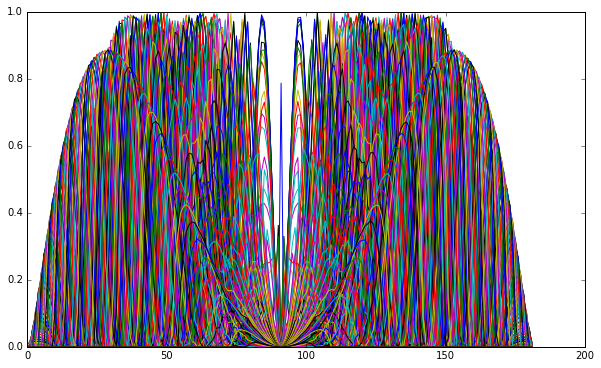

In [1247]:
plt.plot(im2)

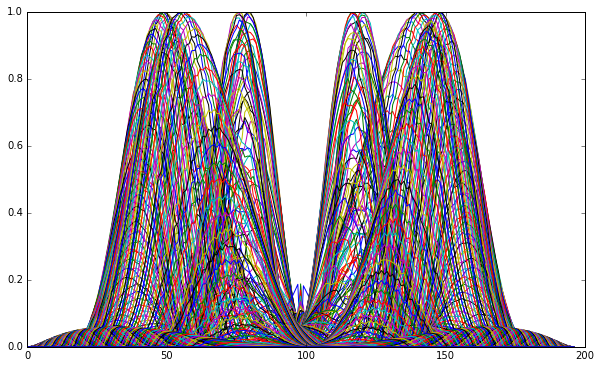

In [1095]:
plt.plot(im4)

(-1.0, 1.0, -1.0, 1.0)

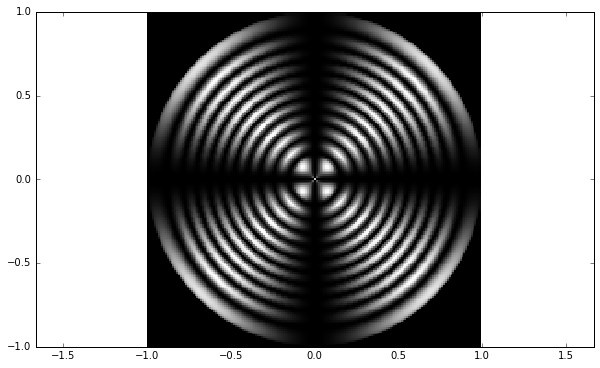

In [1248]:
plt.pcolor(x,y,im2,cmap=plt.cm.gray)
plt.axis('equal')

(-30.0, 30.0, -30.0, 30.0)

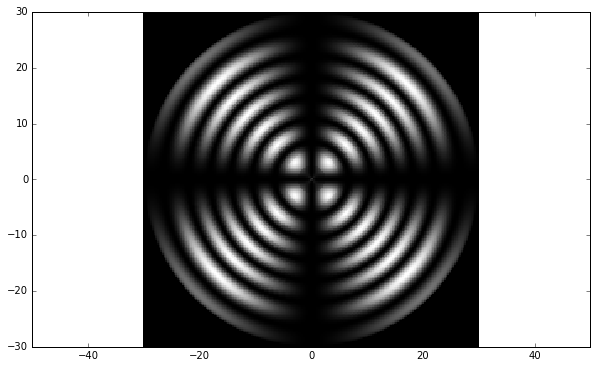

In [1127]:
plt.pcolor(x,y,im2,cmap=plt.cm.gray)
plt.axis('equal')

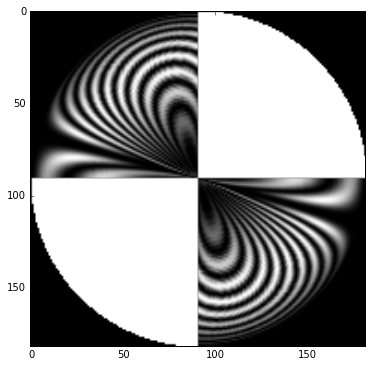

In [1216]:
fig=plt.imshow(im2)

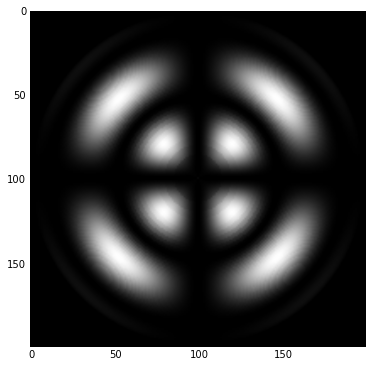

In [1108]:
fig=plt.imshow(im2)